In [71]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from os import walk
import re
from scipy.signal import savgol_filter
from scipy.signal import find_peaks, find_peaks_cwt, detrend
from scipy import signal

import traceback
import sys

import matplotlib.gridspec as gridspec
import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')

from Methods.Methods import * # collection of processing methods in _Methods directory

In [2]:
def calculate_regression_line_stress_strain(Strain,Stress):
        #x = Strain, y = Stress_N_msquared
        #y = self.data['Stress_N_msquared'].values
        #x = self.data['Strain'].values

        #solve LLS Optimization problem min ||y - Phi*Theta||_2^2, Phi being [[1, x_0]^T,...,[1,x_N]^T]T
        Phi = np.array([np.ones(len(Strain)),Strain.values]).T
        Theta = np.linalg.inv(Phi.T @ Phi)@Phi.T @ Stress
        return Theta

In [65]:
#obtain all sample names and respective paths in given directory
data_dir = r'D:\02_RESEARCH\08_Dynamic Mechanical Analysis\Messungen\Neuer Ordner\CSV'
dic = getFileContent(data_dir)

d = {}
for key in dic.keys(): 
    sample = key.split('.')[0]
    value = dic[key]
    d[sample] = value
    #dic = [s.split('.')[0] for s in dic.keys()]

In [90]:
#load geometry data from excel file
geometries = pd.read_excel(r'D:\02_RESEARCH\08_Dynamic Mechanical Analysis\Messungen\Neuer Ordner\DMA_BoseRolauffs_2020-12-22.xlsx',sheet_name='Geometrie')

#only keep data for cyclical experiments
geometries = geometries[geometries.zyklisch == 'x']
geometries = geometries[geometries.kept == 'x']
geometries.Probe = geometries.Probe.astype('Int32').astype('str')  
geometries['gel'] = geometries.Protein.str.replace('-','').str.lstrip('V')+'-'+geometries.Probe
geometries['Geldicke'] = 0.580

#only keep necessary columns
df_geometries = geometries[['gel','Gelbreite','Geldicke','Spaltbreite']]
df_geometries.head()

,gel,Gelbreite,Geldicke,Spaltbreite
4,20-1,3.0,0.58,3.0
6,20-2,2.8,0.58,2.8
8,20-3,3.0,0.58,2.0
10,20-4,3.0,0.58,2.5
14,20-6,3.0,0.58,1.5


In [107]:
from matplotlib import interactive
%matplotlib notebook 

list_youngs = []
for sample in dic.keys(): 
    
    try:
        #colum names
        names = ['Points','Elapsed_Time','Scan_Time','Disp','Load','E12_%','E22_%','Axial_cmd_V','Axial_err_%','Unnamed']

        #get path from sample dictionary
        path = dic[sample]
        #print('Processing sample {} in path {}'.format(sample,path) )
        #path = r'D:\02_RESEARCH\08_Dynamic Mechanical Analysis\Messungen\Neuer Ordner\CSV\20-6.1.csv'
        header = 100

        #print(sample)
        #load data into dataframe
        df = pd.read_csv(path,header=1000,names=names,index_col=False)
        df['source'] = 'source'

        #drop duplicate row
        df = df.drop_duplicates(subset='Elapsed_Time',keep='first')

        #create walking continuous index
        df.Points = [i for i in range(1, len(df) + 1)]

        #keep 10000 points
        df = df[:10000]
        
        #convert displacement into meters
        df.Disp = 0.001*df.Disp
        
        #smoothen data 
        df['Load_sav'] = savgol_filter(df.Load,21,1)

        #detrend data
        df['Load_sav_det'] = detrend(df.Load_sav)

        split_up_data = []
        thetas = []

        '''
        f = plt.figure(figsize=(14,12))
        ax = f.add_subplot(2,1,1)
        ax1 = f.add_subplot(2,1,2)
        '''

        for i in range(10):
            tmp = df[i*1000:(i+1)*1000]

            '''
            tmp.Load.plot(ax=ax,alpha=0.25)
            tmp.Load_sav_det.plot(ax=ax)
            '''
            #calculate youngs modulus
            theta_temp = calculate_regression_line_stress_strain(Strain=tmp.Disp,Stress=tmp.Load_sav_det)

            '''
            #plot ellipses
            tmp.plot(x='Disp',y='Load_sav_det',ax=ax1,alpha=0.25)

            #plot youngs modulus
            x = tmp.Disp.values
            Phi = np.array([np.ones(len(x)),x]).T
            y = Phi@theta_temp
            plt.plot(x,y)

            tmp['theta'] = theta_temp[1]
            split_up_data.append(tmp)
            '''
            thetas.append(theta_temp[1])
        df_thetas = pd.DataFrame(thetas)
        '''
        print('E: max: {:.3f}, min: {:.3f}, mean: {:.3f}, std: {:.6f}'.format(np.max(thetas),
                                                                              np.min(thetas),
                                                                              np.mean(thetas),
                                                                              np.std(thetas)))
        '''
        list_youngs.append([path,
                            np.max(thetas),
                            np.min(thetas),
                            np.mean(thetas),
                            np.std(thetas),
                            sample, 
                            sample.split('.')[0]])
    
    except Exception as err:
        print('Error')
        #print('File: ', dic[sample])
        #print(traceback.format_exc())
        #print(4*'======================')
df_youngs = pd.DataFrame(list_youngs, columns=['Path',
                                               'theta_Maximum',
                                               'theta_Minimum',
                                               'theta_Mean',
                                               'theta_Std',
                                               'sample',
                                               'gel'])
df_full = pd.merge(df_youngs,df_geometries,how='outer',on='gel')

#transform linear coefficient theta into youngs modulus
df_full['E_Maximum'] = df_full.theta_Maximum*df_full.Spaltbreite*0.001/(df_full.Geldicke*0.001 * df_full.Gelbreite*0.001)
df_full['E_Minimum'] = df_full.theta_Minimum*df_full.Spaltbreite*0.001/(df_full.Geldicke*0.001 * df_full.Gelbreite*0.001)
df_full['E_Mean'] = df_full.theta_Mean*df_full.Spaltbreite*0.001/(df_full.Geldicke*0.001 * df_full.Gelbreite*0.001)
df_full['E_Std'] = df_full.theta_Std*df_full.Spaltbreite*0.001/(df_full.Geldicke*0.001 * df_full.Gelbreite*0.001)
df_full = df_full[['gel','sample','E_Maximum','E_Minimum','E_Mean','E_Std']]

df_full


Error
Error
Error
Error
Error


c:\users\alexander resch\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


,gel,sample,E_Maximum,E_Minimum,E_Mean,E_Std
0,20-2,20-2.1.CSV,604398.280858,577136.675001,591211.747143,9495.019927
1,20-2,20-2.2.CSV,460974.242221,451022.064475,454864.527711,2801.951764
2,20-2,20-2.3.CSV,-36052.762415,-41701.746319,-39518.258202,1646.492448
3,20-3,20-3.1.CSV,454465.089054,431186.872583,446530.419390,6697.403011
4,20-3,20-3.2.CSV,341689.196631,330892.152528,336644.602084,3243.980049
...,...,...,...,...,...,...
70,40RGD-7,40RGD-7.3.CSV,-19843.095963,-20953.591319,-20426.066475,297.107349
71,Wasser1,Wasser1.1.CSV,NaN,NaN,NaN,NaN
72,Wasser1,Wasser1.2.CSV,NaN,NaN,NaN,NaN
73,Wasser1,Wasser1.3.CSV,NaN,NaN,NaN,NaN


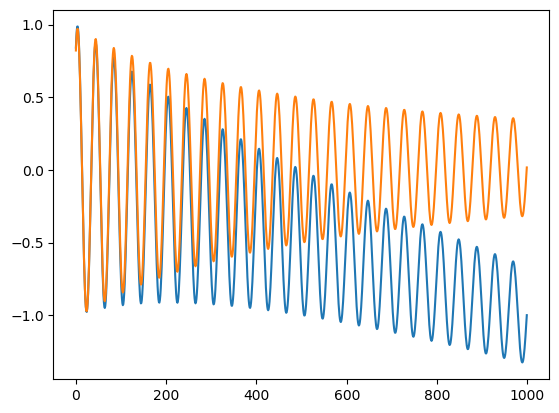

In [75]:
t = np.linspace(1,50*np.pi,1000)
scale = np.linspace(1,3,1000)
scaley = np.linspace(0,1,1000)

y = np.sin(t)
y = np.true_divide(y,scale)-scaley
plt.plot(y)

plt.plot(detrend(y))